# 准备

## 首先的首先，用哪个数据库训练

In [1]:
GSE_Train = "GSE63990"

## 库 导入

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score
warnings.filterwarnings('ignore')

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC

## 数据 导入

In [4]:
gse = GEOparse.get_GEO(geo=GSE_Train, destdir="./datasets", silent=True)
gpls = gse.metadata['platform_id']
gpl = GEOparse.get_GEO(geo=gpls[0], destdir="./datasets", silent=True)

In [5]:
gse_csv = pd.read_csv('./datasets/' + GSE_Train + '.csv')
gse_csv.head() # 预览数据

,infection_status,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
0,non-infectious illness,107.026284,158.817338,2545.754898,186.244424,13.132469,643.402073,34.615676,17.490946,2929.019555,...,17.173226,422.464901,566.805882,481.918815,1421.477295,1302.020303,6250.362334,3836.600257,17740.725022,14961.589573
1,non-infectious illness,221.020421,124.644738,2143.929143,324.223899,15.427804,1001.622909,49.833883,22.848206,5667.531661,...,17.962223,652.117965,800.852865,822.133404,2305.851262,2008.050881,8731.397156,5399.129367,19067.890695,17285.989865
2,non-infectious illness,137.091142,115.353642,1741.194207,299.526479,13.588461,549.283988,47.869510,18.544460,3186.032084,...,17.282754,483.392556,566.237470,586.430031,1792.943487,1330.467773,7401.441597,4578.962962,18303.281696,15753.041045
3,non-infectious illness,126.175162,98.119250,1316.526914,326.999326,12.738011,339.984798,51.808930,19.624606,5535.493091,...,17.651712,1275.694498,1781.291882,1547.788940,3845.464156,3549.057271,11770.475723,7924.052042,23370.081259,19856.779557
4,bacterial,105.348086,260.359324,2930.300695,223.766173,12.436344,409.723526,35.071703,19.844859,581.984161,...,18.275624,404.702873,518.880900,477.676689,1299.615932,1186.047735,5968.686731,3780.851630,18440.196387,15535.017110


In [6]:
gse_csv.isnull().sum() 

infection_status        0
1007_s_at               0
1053_at                 0
117_at                  0
121_at                  0
                       ..
AFFX-r2-Ec-bioC-5_at    0
AFFX-r2-Ec-bioD-3_at    0
AFFX-r2-Ec-bioD-5_at    0
AFFX-r2-P1-cre-3_at     0
AFFX-r2-P1-cre-5_at     0
Length: 22278, dtype: int64

In [7]:
gse_csv['infection_status'].value_counts() # 看一下感染这个列的分布

viral                     117
non-infectious illness     90
bacterial                  73
Name: infection_status, dtype: int64

In [66]:
type(gse_csv)

pandas.core.frame.DataFrame

In [67]:
# gse_csv的维度
gse_csv.shape

(280, 22278)

## 函数 准备

In [8]:
def plot_score_distribution(ax, y_score, final_target):
    ax.scatter(range(len(y_score)), y_score, c=final_target, cmap='bwr', alpha=0.5)
    ax.set_title('分数分布图')
    ax.set_xlabel('样本序号')
    ax.set_ylabel('分数')
    plt.rcParams['font.sans-serif']=['SimHei'] # 中文乱码
    plt.rcParams['axes.unicode_minus']=False # 负号乱码
    labels = ['细菌感染', '病毒感染']
    ax.legend(labels, loc='upper right')
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')

def plot_roc_curve(ax, y_score, final_target):
    fpr, tpr, thresholds = roc_curve(final_target, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate 假阳性率')
    ax.set_ylabel('True Positive Rate 真阳性率')
    ax.set_title('ROC 曲线（受试者工作特征曲线）')
    ax.legend(loc="lower right")

def plot_pr_curve(ax, y_score, final_target):
    precision, recall, thresholds = precision_recall_curve(final_target, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
    ax.set_xlabel('Recall 召回率')
    ax.set_ylabel('Precision 准确率')
    ax.set_title('PR 曲线（准确率-召回率曲线）')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left")

def plot_confusion_matrix(ax, y_score, final_target):
    y_pred = np.where(y_score > 0.5, 1, 0)
    cnf_matrix = confusion_matrix(final_target, y_pred)
    ax.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix 混淆矩阵')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['病毒感染', '细菌感染'], rotation=45)
    plt.yticks(tick_marks, ['病毒感染', '细菌感染'])
    thresh = cnf_matrix.max() / 2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j],horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label 感染情况')
    plt.xlabel('Predicted label 预测情况')

def plot_all(score, target, title="分数分布图、ROC曲线、PR曲线和混淆矩阵", feature=None, weight=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    plot_score_distribution(axs[0,0], score, target)
    plot_roc_curve(axs[0,1], score, target)
    plot_pr_curve(axs[1,0], score, target)
    plot_confusion_matrix(axs[1,1], score, target)
    if feature or weight:
        try:
            # add margin at bottom
            fig.subplots_adjust(bottom=0.12)
            # add feature and weight at the bottom
            fig.text(0.5, 0.04, '使用feature:'+str(feature), ha='center', va='bottom', fontsize=12)
            fig.text(0.5, 0.02, '对应权重:'+str(weight), ha='center', va='bottom', fontsize=12)
        except:
            pass
    return fig, axs

def testfeature(feature,weight,data,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['infection_status'].values
    except:
        target = gse_csv['infection_status']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

def testfeaturewithtimes(feature,weight,data,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['infection_status'].values
    except:
        target = gse_csv['infection_status']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

def testfeaturewithtimesandtarget(feature,weight,data,target,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)


# 训练

## 分开病毒与未感染

In [126]:
# 病毒与未感染的鉴别
viral_data = gse_csv[gse_csv['infection_status'] != 'bacterial']
viral_data['infection_status'] = viral_data['infection_status'].map({'viral': 1, 'non-infectious illness': 0})
X_train, X_test, y_train, y_test = train_test_split(viral_data.drop(['infection_status'], axis=1), viral_data['infection_status'], test_size=0.2, random_state=0)
viral_data['infection_status'].value_counts()

1    117
0     90
Name: infection_status, dtype: int64

### 仅在 感染了后表达量的75%高于未感染的表达量的25%的基因中进行训练

In [11]:
viral_data = gse_csv[gse_csv['infection_status'] != 'bacterial']
viral_data['infection_status'].value_counts()
viral_data['infection_status'] = viral_data['infection_status'].map({'viral': 1, 'non-infectious illness': 0})
viral_data_describe = viral_data.groupby('infection_status').describe()
viral_data_higher_columns = []
viral_data_higher_columns.append('infection_status')
for i in range(viral_data_describe.shape[1]//8):
    # if the feature is not significant, that means, the mean of the viral ones is smaller than two times of the non-viral ones, drop it
    if (viral_data_describe.iloc[1,8*i+4]>
        viral_data_describe.iloc[0,8*i+6]):
        viral_data_higher_columns.append(viral_data_describe.columns[8*i+1][0])
viral_data_higher = viral_data[viral_data_higher_columns]
X_train, X_test, y_train, y_test = train_test_split(viral_data_higher.drop(['infection_status'], axis=1), viral_data_higher['infection_status'], test_size=0.2, random_state=0)
viral_data_higher

,infection_status,1294_at,200039_s_at,200041_s_at,200079_s_at,200600_at,200609_s_at,200618_at,200628_s_at,200629_at,...,55081_at,55662_at,57539_at,58994_at,60815_at,64408_s_at,64418_at,65630_at,AFFX-HSAC07/X00351_3_at,AFFX-HUMISGF3A/M97935_MB_at
0,0,643.402073,1340.549577,2920.802108,1419.365924,4557.693902,4211.947387,5304.629225,460.473715,1860.334880,...,240.855718,115.113468,356.914854,114.262220,40.352618,141.662588,523.030339,374.506849,21429.690894,190.122350
1,0,1001.622909,1727.275541,3878.535228,1788.372821,5914.227686,3911.342833,5342.411764,558.175089,2735.839120,...,296.189562,135.658500,496.593307,180.740581,46.388023,92.985173,474.472973,316.683748,19431.802210,89.211071
2,0,549.283988,965.861153,2902.943404,641.568088,6279.198785,4901.682965,5895.095052,399.272341,1619.061879,...,325.405783,74.756361,334.575812,126.928085,45.617479,64.890126,560.378859,290.250529,21529.355181,162.819594
3,0,339.984798,429.112173,1598.055546,873.192833,3866.060797,2867.456768,3791.391837,337.044829,1261.151562,...,156.420044,38.312478,200.171773,53.097219,68.636824,35.876727,248.602802,199.961604,19070.579193,135.533155
5,0,483.260626,1254.537213,3068.325644,926.174495,4646.376351,4252.613571,5122.562762,559.246683,1925.297333,...,219.780298,96.185508,283.554302,81.860539,72.684194,102.826453,505.536694,269.521803,21949.228645,295.993599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,1,777.372259,1083.696568,2055.250235,1225.333559,4087.528550,2186.895228,3926.748105,1787.933234,6262.359667,...,456.601912,53.792385,209.661875,94.393682,35.474495,60.265760,386.083388,131.407759,18560.572302,572.047929
273,0,365.191010,793.564708,2060.528352,890.080761,4067.542196,1860.013447,3327.607824,501.686756,1568.497612,...,166.070205,45.942884,206.404085,95.659533,36.005051,49.054269,326.751666,110.776658,17771.303527,168.677724
275,1,1278.450771,1224.402424,1675.206305,1332.265013,3598.271715,2145.707717,3663.414032,2397.555219,7614.845028,...,453.841597,72.422027,175.066455,71.203667,33.382782,63.851170,439.249347,133.913837,16452.297820,1114.683489
276,1,727.149062,1241.717262,3535.047127,1154.138580,5159.046030,2633.669819,4545.741801,425.725281,1626.407254,...,372.024840,121.165007,315.168220,98.035507,49.436194,75.272339,674.076969,161.641860,19614.955512,397.825792


### 再选一些画图看看

选

In [22]:
# select the best 30 features
k = 49
SelectKBest_chi2 = SelectKBest(chi2, k=k).fit(X_train, y_train)
SelectKBest_f_classif = SelectKBest(f_classif, k=k).fit(X_train, y_train)

select = [SelectKBest_chi2, SelectKBest_f_classif]
select_name = ['SelectKBest_chi2', 'SelectKBest_f_classif']

violinplot

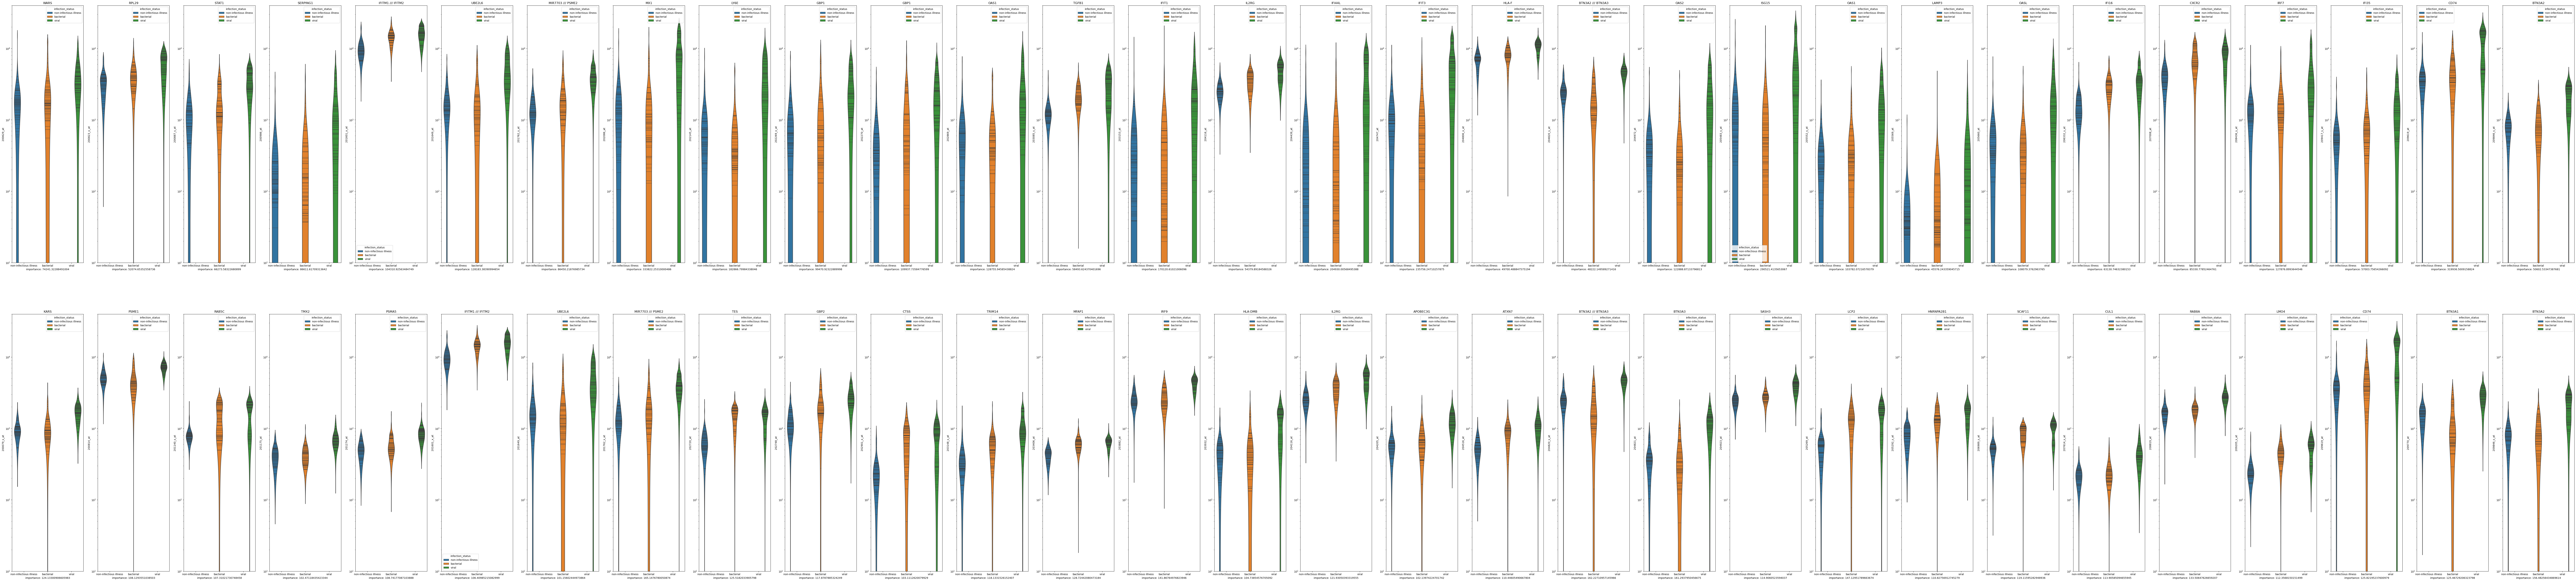

In [98]:
# fig, ax = plt.subplots(len(select), k, figsize=(6*k, 40))
# for i in range(len(select)):
#     for j in range(k):
#         sns.violinplot(
#             x='infection_status', 
#             y=X_train.columns[select[i].get_support(indices=True)[j]], 
#             hue='infection_status',
#             inner='stick',
#             data=gse_csv, ax=ax[i][j])
#         ax[i][j].set_title(gpl.table[gpl.table['ID'] == X_train.columns[select[i].get_support(indices=True)[j]]]['Gene Symbol'].values[0])
#         # also add importance of the gene
#         ax[i][j].set_xlabel('importance: ' + str(select[i].scores_[select[i].get_support(indices=True)[j]]))
#         #对数坐标
#         ax[i][j].set_yscale('log')
#         # y is 0 to 10000
#         ax[i][j].set_ylim(10, 40000)
# plt.show()

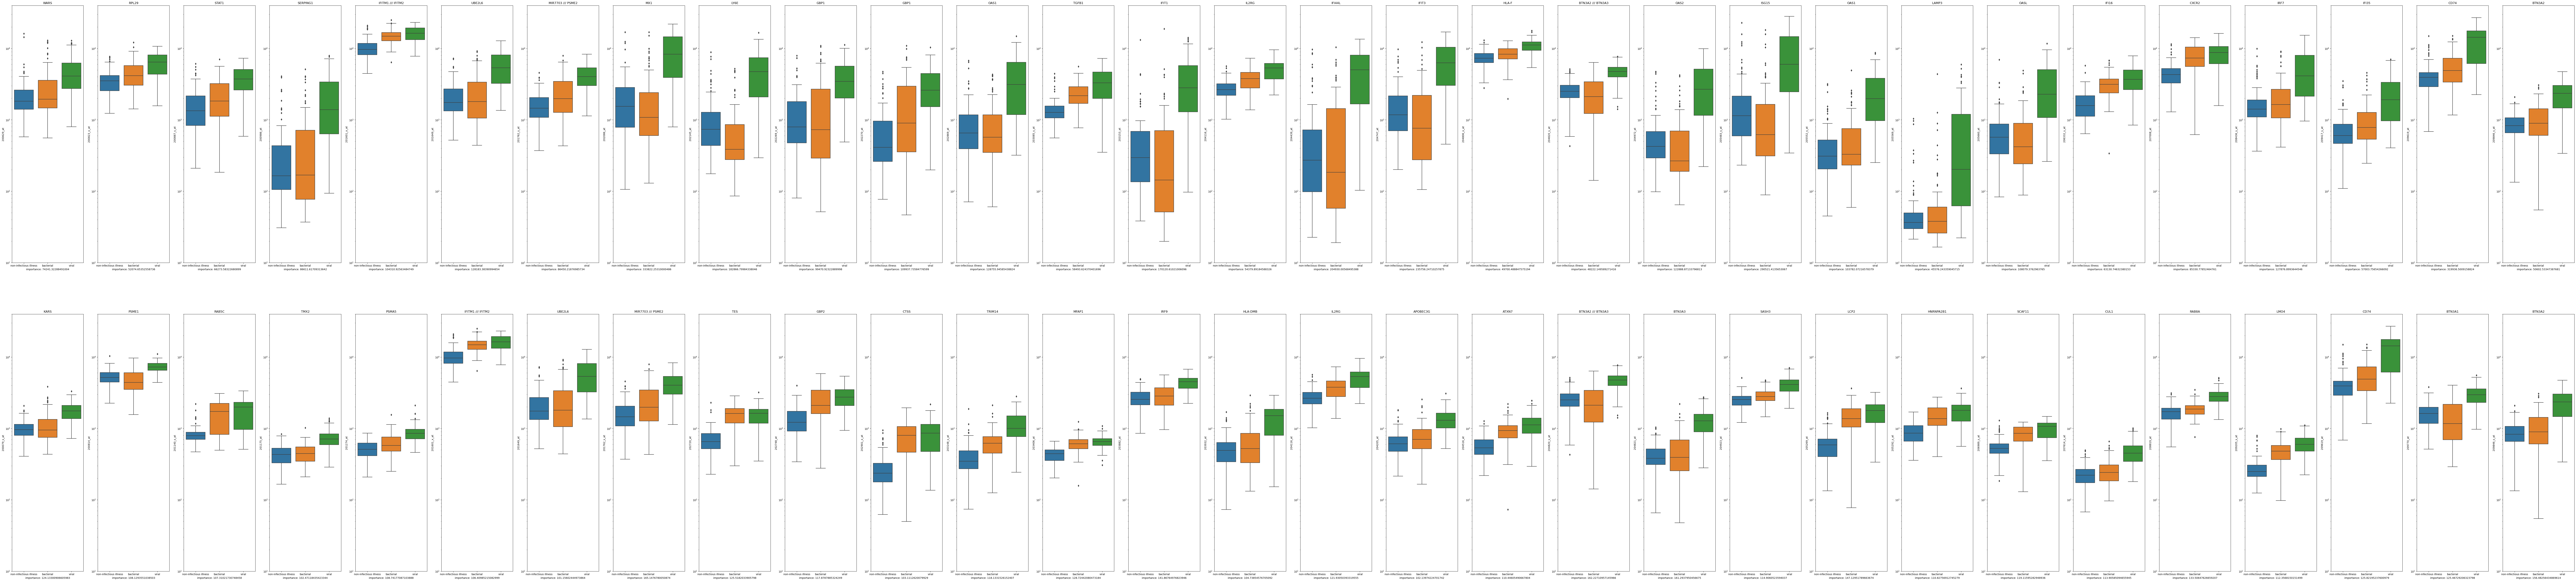

In [111]:
fig, ax = plt.subplots(len(select), k, figsize=(6*k, 40))
for i in range(len(select)):
    for j in range(k):
        sns.boxplot(
            x='infection_status', 
            y=X_train.columns[select[i].get_support(indices=True)[j]], 
            data=gse_csv, ax=ax[i][j])
        ax[i][j].set_title(gpl.table[gpl.table['ID'] == X_train.columns[select[i].get_support(indices=True)[j]]]['Gene Symbol'].values[0])
        # also add importance of the gene
        ax[i][j].set_xlabel('importance: ' + str(select[i].scores_[select[i].get_support(indices=True)[j]]))
        #对数坐标
        ax[i][j].set_yscale('log')
        # y is 0 to 10000
        ax[i][j].set_ylim(10, 40000)
plt.show()

看看在范围内 使用不同的采样的效果

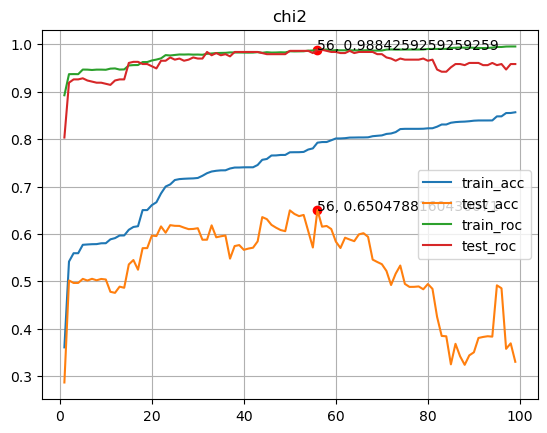

In [113]:
lr = LinearRegression()
train_acc,test_acc,train_roc,test_roc = [],[],[],[]
for i in range(1, 100):
    # reselect the features
    reselect = SelectKBest(score_func=chi2, k=i)
    reselect.fit(X_train, y_train)
    lr.fit(X_train.iloc[:, reselect.get_support(indices=True)], y_train) # use the selected features to train the data
    y_pred = lr.predict(X_test.iloc[:, reselect.get_support(indices=True)])
    train_acc.append(lr.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
    test_acc.append(lr.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))
    train_roc.append(roc_auc_score(y_train, lr.predict(X_train.iloc[:, reselect.get_support(indices=True)])))
    test_roc.append(roc_auc_score(y_test, lr.predict(X_test.iloc[:, reselect.get_support(indices=True)])))
# draw a line chart
plt.plot(range(1, 100), train_acc, label='train_acc')
plt.plot(range(1, 100), test_acc, label='test_acc')
plt.plot(range(1, 100), train_roc, label='train_roc')
plt.plot(range(1, 100), test_roc, label='test_roc')
plt.title('chi2')
plt.legend()
# grid
plt.grid()
# mark the maximum value
plt.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='r')
plt.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str(max(test_acc)))
plt.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
plt.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str(max(test_roc)))
plt.show()



[0.5032724260280355, 0.5662389402448944, 0.5690025693536681, 0.5724759416841917, 0.5742383328392477, 0.5902758619947677, 0.623747850867705, 0.6310768457064222, 0.6465010507389275, 0.6525117977036756, 0.6540318612011413, 0.6550936548362973, 0.6597431296959079, 0.6709859814927375, 0.6730025378401621, 0.6765792732591698, 0.678750808153626, 0.6787914354194202, 0.6787973546345363, 0.6843454565787424, 0.6885236977234404, 0.6886023173259586, 0.7012886908324097, 0.7015269762934538, 0.7036513810502881, 0.7047403499792646, 0.7071724320163518, 0.7071866679398858, 0.7129412165190678, 0.7139620114534408, 0.7157370987717663, 0.7187653034551227, 0.7194366655427096, 0.7195475606612849, 0.7201028337855981, 0.7258025142642361, 0.7263381537197, 0.7309391606821282, 0.73738310159808, 0.7405906318139299, 0.7410562576749639, 0.7415825422518743, 0.7436451586409512, 0.7438870889162139, 0.7482824900636755, 0.7506458480572865, 0.7520460868609563, 0.7533319578241284]


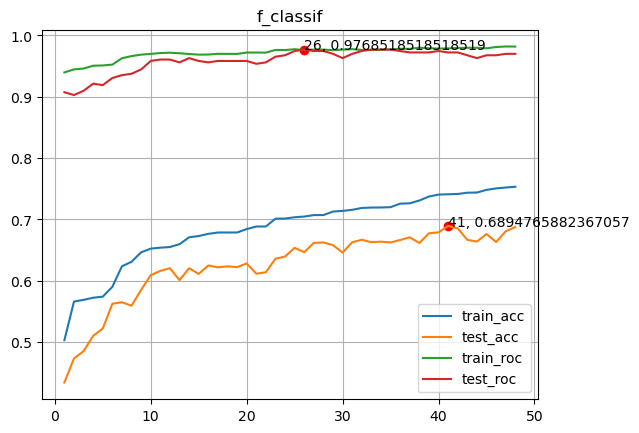

In [114]:
lr = LinearRegression()
train_acc,test_acc,train_roc,test_roc = [],[],[],[]
for i in range(1, 49):
    reselect = SelectKBest(f_classif, k=i).fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    X_test_new = reselect.transform(X_test)
    lr.fit(X_train_new, y_train)
    train_acc.append(lr.score(X_train_new, y_train))
    test_acc.append(lr.score(X_test_new, y_test))
    train_roc.append(roc_auc_score(y_train, lr.predict(X_train_new)))
    test_roc.append(roc_auc_score(y_test, lr.predict(X_test_new)))

print(train_acc)

# draw a line chart
plt.plot(range(1, 49), train_acc, label='train_acc')
plt.plot(range(1, 49), test_acc, label='test_acc')
plt.plot(range(1, 49), train_roc, label='train_roc')
plt.plot(range(1, 49), test_roc, label='test_roc')
plt.title('f_classif')
plt.legend()
# grid
plt.grid()
# mark the maximum value
plt.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='r')
plt.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str(max(test_acc)))
plt.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
plt.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str(max(test_roc)))
plt.show()

[0.3822131108092448, 0.5120655903284779, 0.5527218874859057, 0.5842754872330849, 0.5957676421419518, 0.597438188355395, 0.5990074992564653, 0.6061759884616809, 0.6067581489996715, 0.6087755969167372, 0.6088264226697536, 0.6102414269952293]


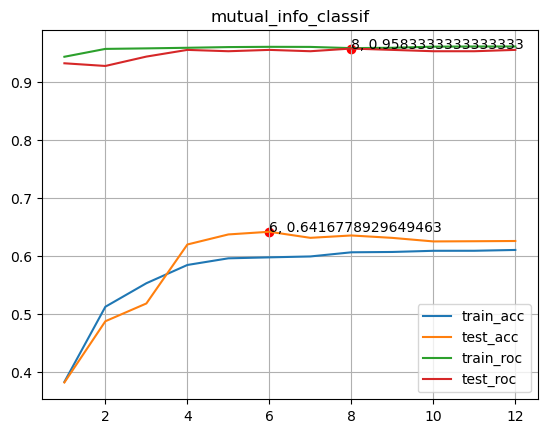

In [116]:
lr = LinearRegression()
train_acc,test_acc,train_roc,test_roc = [],[],[],[]
n = 13
for i in range(1, n):
    reselect = SelectKBest(mutual_info_classif, k=i).fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    X_test_new = reselect.transform(X_test)
    lr.fit(X_train_new, y_train)
    train_acc.append(lr.score(X_train_new, y_train))
    test_acc.append(lr.score(X_test_new, y_test))
    train_roc.append(roc_auc_score(y_train, lr.predict(X_train_new)))
    test_roc.append(roc_auc_score(y_test, lr.predict(X_test_new)))

print(train_acc)

# draw a line chart
plt.plot(range(1, n), train_acc, label='train_acc')
plt.plot(range(1, n), test_acc, label='test_acc')
plt.plot(range(1, n), train_roc, label='train_roc')
plt.plot(range(1, n), test_roc, label='test_roc')
plt.title('mutual_info_classif')
plt.legend()
# grid
plt.grid()
# mark the maximum value
plt.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='r')
plt.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str(max(test_acc)))
plt.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
plt.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str(max(test_roc)))
plt.show()

In [117]:
reselect = SelectKBest(mutual_info_classif, k=6).fit(X_train, y_train)
X_train_new = reselect.transform(X_train)
X_test_new = reselect.transform(X_test)
lr.fit(X_train_new, y_train)
y_pred = lr.predict(X_test.iloc[:, reselect.get_support(indices=True)])
print("train_acc: ", lr.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
print("test_acc: ", lr.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))

train_acc:  0.597438188355395
test_acc:  0.6416778929649463


In [118]:
print(lr.coef_)

[ 7.14002585e-05 -9.00261720e-05  3.77095518e-04  1.09512915e-04
  1.80913434e-03 -2.18196597e-05]


In [119]:
# only use 正 的 features
X_train_new = X_train.iloc[:, reselect.get_support(indices=True)]
X_test_new = X_test.iloc[:, reselect.get_support(indices=True)]
X_train_new = X_train_new.iloc[:, lr.coef_ > 0]
X_test_new = X_test_new.iloc[:, lr.coef_ > 0]
lr.fit(X_train_new, y_train)
y_pred = lr.predict(X_test_new)
print("train_acc: ", lr.score(X_train_new, y_train))
print("test_acc: ", lr.score(X_test_new, y_test))
print("train_roc: ", roc_auc_score(y_train, lr.predict(X_train_new)))
print("test_roc: ", roc_auc_score(y_test, lr.predict(X_test_new)))
print(lr.coef_)

train_acc:  0.5951059758847166
test_acc:  0.6334595696503766
train_roc:  0.9602747909199522
test_roc:  0.9537037037037037
[6.03536270e-05 3.10459226e-04 1.00856233e-04 1.69997083e-03]


In [120]:
gene_id = X_test_new.columns
gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
gene_symbol

['MIR7703 /// PSME2', 'DRAP1', 'BTN3A2', 'HLA-F-AS1']

0 [0. 0. 0. 0.] 0.42857142857142855
1 [0. 1. 0. 5.] 0.5952380952380952
2 [ 0.  2.  1. 10.] 0.6904761904761905
3 [ 1.  3.  1. 15.] 0.8571428571428571
4 [ 1.  4.  1. 20.] 0.8333333333333334
5 [ 1.  5.  2. 25.] 0.8095238095238095
6 [ 1.  6.  2. 31.] 0.8095238095238095
7 [ 1.  7.  2. 36.] 0.8095238095238095
8 [ 1.  7.  2. 41.] 0.7380952380952381
9 [ 2.  8.  3. 46.] 0.7857142857142857
10 [ 2.  9.  3. 51.] 0.8095238095238095
11 [ 2. 10.  3. 56.] 0.8095238095238095
12 [ 2. 11.  4. 61.] 0.8095238095238095
13 [ 2. 12.  4. 66.] 0.8095238095238095
14 [ 3. 13.  4. 71.] 0.7857142857142857
15 [ 3. 14.  5. 76.] 0.7857142857142857
16 [ 3. 15.  5. 82.] 0.8333333333333334
17 [ 3. 16.  5. 87.] 0.7857142857142857
18 [ 3. 17.  5. 92.] 0.8095238095238095
19 [ 3. 18.  6. 97.] 0.8095238095238095
20 [  4.  19.   6. 102.] 0.7857142857142857
21 [  4.  20.   6. 107.] 0.8095238095238095
22 [  4.  20.   7. 112.] 0.8095238095238095
23 [  4.  21.   7. 117.] 0.8095238095238095
24 [  4.  22.   7. 122.] 0.80952380952380

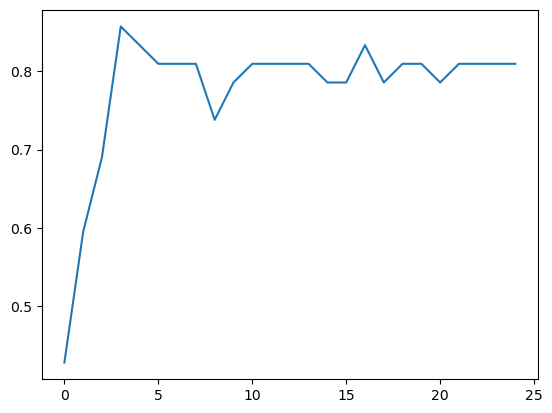

In [123]:
# draw a line chart
test_acc = []
coefs = []
for times in range(0, 25):
    coef = np.round(times*lr.coef_*3000, 0)
    coefs.append(coef)
    y_pred01 = np.zeros(len(y_test))
    for i in range(len(y_pred)):
        y_pred[i] = 0
        for j in range(3):
            y_pred[i] += X_test.iloc[:, reselect.get_support(indices=True)].values[i][j] * coef[j]
        if y_pred[i] > 0.5*3000*times:
            y_pred01[i] = 1
        else:
            y_pred01[i] = 0
    test_acc.append(np.sum(y_pred01 == y_test.values) / len(y_pred01))
    print(times, coef, test_acc[times]) 

plt.plot(range(25), test_acc, label='test_acc')
# draw a line of lr.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test)
# plt.plot(range(25), [lr.score(X_test_new.iloc[:, reselect.get_support(indices=True)], y_test)]*25, label='lr.score')

## 细菌

In [127]:
# 病毒与未感染的鉴别
bacterial_data = gse_csv[gse_csv['infection_status'] != 'viral']
bacterial_data['infection_status'] = bacterial_data['infection_status'].map({'bacterial': 1, 'non-infectious illness': 0})
X_train, X_test, y_train, y_test = train_test_split(bacterial_data.drop(['infection_status'], axis=1), bacterial_data['infection_status'], test_size=0.2, random_state=0)
bacterial_data['infection_status'].value_counts()

0    90
1    73
Name: infection_status, dtype: int64

In [128]:
bacterial_data = gse_csv[gse_csv['infection_status'] != 'viral']
bacterial_data['infection_status'].value_counts()
bacterial_data['infection_status'] = bacterial_data['infection_status'].map({'bacterial': 1, 'non-infectious illness': 0})
bacterial_data_describe = bacterial_data.groupby('infection_status').describe()
bacterial_data_higher_columns = []
bacterial_data_higher_columns.append('infection_status')
for i in range(bacterial_data_describe.shape[1]//8):
    # if the feature is not significant, that means, the mean of the viral ones is smaller than two times of the non-viral ones, drop it
    if (bacterial_data_describe.iloc[1,8*i+4]>
        bacterial_data_describe.iloc[0,8*i+6]):
        bacterial_data_higher_columns.append(bacterial_data_describe.columns[8*i+1][0])
bacterial_data_higher = bacterial_data[bacterial_data_higher_columns]
X_train, X_test, y_train, y_test = train_test_split(bacterial_data_higher.drop(['infection_status'], axis=1), bacterial_data_higher['infection_status'], test_size=0.2, random_state=0)
bacterial_data_higher

,infection_status,200096_s_at,200600_at,200603_at,200609_s_at,200618_at,200639_s_at,200640_at,200663_at,200685_at,...,51146_at,52731_at,54051_at,55692_at,58696_at,58994_at,64408_s_at,65630_at,91684_g_at,AFFX-HSAC07/X00351_3_at
0,0,8745.946149,4557.693902,2700.155485,4211.947387,5304.629225,4696.984183,6131.544369,4949.901324,85.366024,...,128.686790,71.104715,73.476434,856.963810,474.150619,114.262220,141.662588,374.506849,200.020365,21429.690894
1,0,7345.101084,5914.227686,485.202244,3911.342833,5342.411764,3525.346038,4068.617414,6392.705022,24.463078,...,66.144907,82.154869,60.832537,538.050526,519.220869,180.740581,92.985173,316.683748,247.730955,19431.802210
2,0,11397.940451,6279.198785,3709.252077,4901.682965,5895.095052,7359.666514,7112.296235,7637.493861,43.087824,...,144.560038,76.700922,127.124461,1942.969205,462.053147,126.928085,64.890126,290.250529,236.344255,21529.355181
3,0,7430.970260,3866.060797,2842.228640,2867.456768,3791.391837,3608.484369,4100.733719,3802.788217,65.942181,...,80.106937,73.078754,71.730044,715.019678,307.820708,53.097219,35.876727,199.961604,195.494086,19070.579193
4,1,8523.085030,3520.345471,4078.964766,4635.864392,4258.433632,5738.776605,6992.318181,10542.374742,177.034866,...,157.194267,72.947263,70.836251,925.610374,428.618047,121.257679,94.161830,255.525729,225.140987,22527.764233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,0,4255.598171,4067.542196,523.171568,1860.013447,3327.607824,2420.737559,2133.202880,3548.316929,13.266013,...,61.313435,70.323795,53.500761,387.218976,301.462968,95.659533,49.054269,110.776658,147.669519,17771.303527
274,1,4695.243588,4297.464879,1301.039860,2813.274311,4134.869547,3780.889683,2936.982010,6147.787866,13.724278,...,82.411962,78.241476,65.203646,780.220201,798.413950,105.845334,44.166145,117.579164,318.315143,18725.252146
277,1,4377.897938,6275.023222,2714.919034,2794.402656,4541.008542,3904.795360,3300.146690,4705.945004,23.746626,...,85.306749,90.260400,55.529563,1015.934161,760.074903,108.144636,53.016349,141.057548,300.245850,21034.067703
278,1,7100.195323,5929.940988,4885.277426,3352.012038,4164.858212,5344.822758,5558.585796,8969.208490,33.422151,...,106.595374,83.245485,59.102298,1673.469738,1935.092937,57.068637,65.509480,132.949208,760.567953,22411.476421


选

[0.3038779978339239, 0.37845165227167077, 0.39610393597674276, 0.41608394601043297, 0.43644755504962607, 0.553819410282756, 0.5572713801148002, 0.5587031068891014, 0.5637057367384364, 0.5766170289215293, 0.5795590768565024, 0.5820245758306757, 0.5882810172037487, 0.5890201087379388]


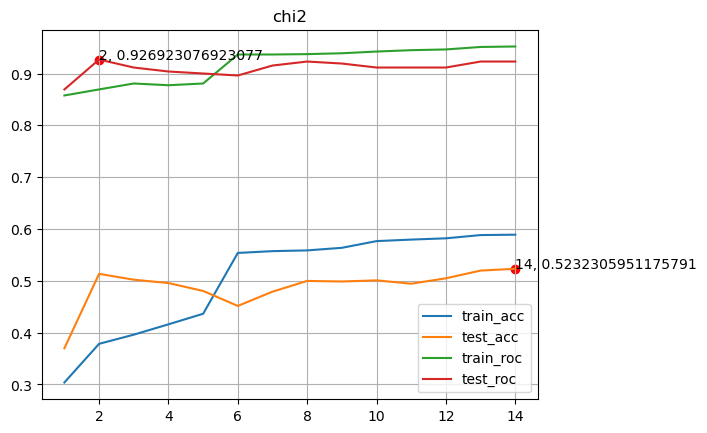

In [130]:
lr = LinearRegression()
train_acc,test_acc,train_roc,test_roc = [],[],[],[]
n = 15
for i in range(1, n):
    reselect = SelectKBest(chi2, k=i).fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    X_test_new = reselect.transform(X_test)
    lr.fit(X_train_new, y_train)
    train_acc.append(lr.score(X_train_new, y_train))
    test_acc.append(lr.score(X_test_new, y_test))
    train_roc.append(roc_auc_score(y_train, lr.predict(X_train_new)))
    test_roc.append(roc_auc_score(y_test, lr.predict(X_test_new)))

print(train_acc)

# draw a line chart
plt.plot(range(1, n), train_acc, label='train_acc')
plt.plot(range(1, n), test_acc, label='test_acc')
plt.plot(range(1, n), train_roc, label='train_roc')
plt.plot(range(1, n), test_roc, label='test_roc')
plt.title('chi2')
plt.legend()
# grid
plt.grid()
# mark the maximum value
plt.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='r')
plt.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str(max(test_acc)))
plt.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
plt.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str(max(test_roc)))
plt.show()

[0.516134160887074, 0.544026066883581, 0.5671996453490701, 0.5673760910865426, 0.5707883624529648, 0.5994485481919207, 0.5995477148222369, 0.6093906887486903, 0.6103951454732081, 0.6163882032363612, 0.6164278857015169, 0.6200753047675311, 0.6247588771943713, 0.6347423129058034]


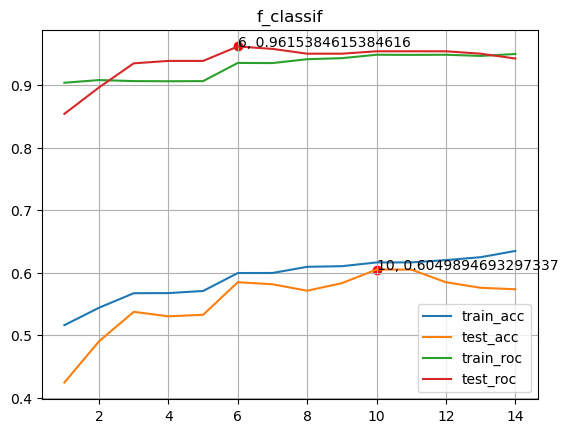

In [131]:
lr = LinearRegression()
train_acc,test_acc,train_roc,test_roc = [],[],[],[]
n = 15
for i in range(1, n):
    reselect = SelectKBest(f_classif, k=i).fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    X_test_new = reselect.transform(X_test)
    lr.fit(X_train_new, y_train)
    train_acc.append(lr.score(X_train_new, y_train))
    test_acc.append(lr.score(X_test_new, y_test))
    train_roc.append(roc_auc_score(y_train, lr.predict(X_train_new)))
    test_roc.append(roc_auc_score(y_test, lr.predict(X_test_new)))

print(train_acc)

# draw a line chart
plt.plot(range(1, n), train_acc, label='train_acc')
plt.plot(range(1, n), test_acc, label='test_acc')
plt.plot(range(1, n), train_roc, label='train_roc')
plt.plot(range(1, n), test_roc, label='test_roc')
plt.title('f_classif')
plt.legend()
# grid
plt.grid()
# mark the maximum value
plt.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='r')
plt.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str(max(test_acc)))
plt.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
plt.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str(max(test_roc)))
plt.show()

[0.516134160887074, 0.544026066883581, 0.5672980216845713, 0.5682303567097373, 0.5867833999641422, 0.5868332937986545, 0.5936412028384288, 0.6271545477820577, 0.6277030838614623, 0.6313793493909355, 0.6322441842115215, 0.6325465982186111, 0.6326056541350966, 0.6358920761175513]


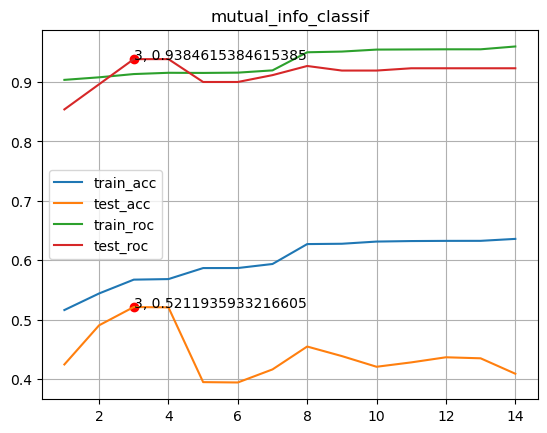

In [132]:
lr = LinearRegression()
train_acc,test_acc,train_roc,test_roc = [],[],[],[]
n = 15
for i in range(1, n):
    reselect = SelectKBest(mutual_info_classif, k=i).fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    X_test_new = reselect.transform(X_test)
    lr.fit(X_train_new, y_train)
    train_acc.append(lr.score(X_train_new, y_train))
    test_acc.append(lr.score(X_test_new, y_test))
    train_roc.append(roc_auc_score(y_train, lr.predict(X_train_new)))
    test_roc.append(roc_auc_score(y_test, lr.predict(X_test_new)))

print(train_acc)

# draw a line chart
plt.plot(range(1, n), train_acc, label='train_acc')
plt.plot(range(1, n), test_acc, label='test_acc')
plt.plot(range(1, n), train_roc, label='train_roc')
plt.plot(range(1, n), test_roc, label='test_roc')
plt.title('mutual_info_classif')
plt.legend()
# grid
plt.grid()
# mark the maximum value
plt.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='r')
plt.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str(max(test_acc)))
plt.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
plt.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str(max(test_roc)))
plt.show()

In [139]:
reselect = SelectKBest(mutual_info_classif, k=3).fit(X_train, y_train)
X_train_new = reselect.transform(X_train)
X_test_new = reselect.transform(X_test)
lr.fit(X_train_new, y_train)
y_pred = lr.predict(X_test.iloc[:, reselect.get_support(indices=True)])
print("train_acc: ", lr.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
print("test_acc: ", lr.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))

train_acc:  0.5672980216845713
test_acc:  0.5211935933216605


In [140]:
print(lr.coef_)

[0.0002022  0.00095769 0.00108993]


In [141]:
# only use 正 的 features
X_train_new = X_train.iloc[:, reselect.get_support(indices=True)]
X_test_new = X_test.iloc[:, reselect.get_support(indices=True)]
X_train_new = X_train_new.iloc[:, lr.coef_ > 0]
X_test_new = X_test_new.iloc[:, lr.coef_ > 0]
lr.fit(X_train_new, y_train)
y_pred = lr.predict(X_test_new)
print("train_acc: ", lr.score(X_train_new, y_train))
print("test_acc: ", lr.score(X_test_new, y_test))
print("train_roc: ", roc_auc_score(y_train, lr.predict(X_train_new)))
print("test_roc: ", roc_auc_score(y_test, lr.predict(X_test_new)))
print(lr.coef_)

train_acc:  0.5672980216845713
test_acc:  0.5211935933216605
train_roc:  0.9133333333333333
test_roc:  0.9384615384615385
[0.0002022  0.00095769 0.00108993]


In [142]:
gene_id = X_test_new.columns
gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
gene_symbol

['TES', 'TK2', 'MTMR4']

0 [0. 0. 0.] 0.6060606060606061
1 [1. 3. 3.] 0.6060606060606061
2 [1. 6. 7.] 0.7575757575757576
3 [ 2.  9. 10.] 0.7272727272727273
4 [ 2. 11. 13.] 0.8484848484848485
5 [ 3. 14. 16.] 0.7575757575757576
6 [ 4. 17. 20.] 0.7575757575757576
7 [ 4. 20. 23.] 0.7575757575757576
8 [ 5. 23. 26.] 0.7575757575757576
9 [ 5. 26. 29.] 0.7878787878787878
10 [ 6. 29. 33.] 0.7575757575757576
11 [ 7. 32. 36.] 0.7575757575757576
12 [ 7. 34. 39.] 0.7575757575757576
13 [ 8. 37. 43.] 0.7575757575757576
14 [ 8. 40. 46.] 0.7575757575757576
15 [ 9. 43. 49.] 0.7575757575757576
16 [10. 46. 52.] 0.7575757575757576
17 [10. 49. 56.] 0.7575757575757576
18 [11. 52. 59.] 0.7575757575757576
19 [12. 55. 62.] 0.7575757575757576
20 [12. 57. 65.] 0.7575757575757576
21 [13. 60. 69.] 0.7575757575757576
22 [13. 63. 72.] 0.7575757575757576
23 [14. 66. 75.] 0.7575757575757576
24 [15. 69. 78.] 0.7575757575757576


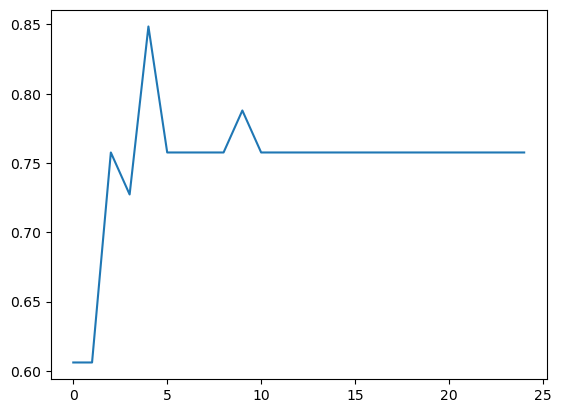

In [144]:
# draw a line chart
test_acc = []
coefs = []
for times in range(0, 25):
    coef = np.round(times*lr.coef_*3000, 0)
    coefs.append(coef)
    y_pred01 = np.zeros(len(y_test))
    for i in range(len(y_pred)):
        y_pred[i] = 0
        for j in range(3):
            y_pred[i] += X_test.iloc[:, reselect.get_support(indices=True)].values[i][j] * coef[j]
        if y_pred[i] > 0.5*3000*times:
            y_pred01[i] = 1
        else:
            y_pred01[i] = 0
    test_acc.append(np.sum(y_pred01 == y_test.values) / len(y_pred01))
    print(times, coef, test_acc[times]) 

plt.plot(range(25), test_acc, label='test_acc')
# draw a line of lr.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test)
# plt.plot(range(25), [lr.score(X_test_new.iloc[:, reselect.get_support(indices=True)], y_test)]*25, label='lr.score')

# 测试